In [1]:
import time
import torch
import numpy as np
import torch.nn as nn
from early_stop import EarlyStopping
from torch.optim import Adam
from models.SVDD_model import SVDD
from dataset import pyg_dataset, pyg_to_dgl
from sklearn.metrics import roc_auc_score

def anomaly_score(node_embedding, c):
    # anomaly score of an instance is calculated by 
    # square Euclidean distance between the node embedding and the center c
    return torch.sum((node_embedding - c) ** 2)

def nor_loss(node_embedding_list, c):
    # normal loss is calculated by mean squared Euclidian distance of 
    # the normal node embeddings to hypersphere center c 
    s = 0
    num_node = node_embedding_list.size()[0]
    for i in range(num_node):
        s = s + anomaly_score(node_embedding_list[i], c)
    return s/num_node

# def AUC_loss(anomaly_node_emb, normal_node_emb, c):
#     # AUC_loss encourages the score of anomaly instances to be higher than those of normal instances
#     s = 0
#     num_anomaly_node = anomaly_node_emb.size()[0]
#     num_normal_node = normal_node_emb.size()[0]
#     for i in range(num_anomaly_node):
#         for j in range(num_normal_node):
#             s1 = anomaly_score(anomaly_node_emb[i], c)
#             s2 = anomaly_score(normal_node_emb[j], c)
#             s = s + torch.sigmoid(s1 - s2)
#     return s/(num_anomaly_node * num_normal_node) # check devide by zero

def AUC_loss(anomaly_node_emb, normal_node_emb, c):
    # AUC_loss encourages the score of anomaly instances to be higher than those of normal instances
    s = 0
    num_anomaly_node = anomaly_node_emb.size()[0]
    num_normal_node = normal_node_emb.size()[0]
    s2_list = []
    for j in range(num_normal_node):
        s2_list.append(anomaly_score(normal_node_emb[j], c))
    for i in range(num_anomaly_node):
            s1 = anomaly_score(anomaly_node_emb[i], c)
            s = s + torch.sigmoid(s1 - torch.tensor(s2_list)).sum()
    return s/(num_anomaly_node * num_normal_node) # check devide by zero

def objecttive_loss(anomaly_node_emb, normal_node_emb, c, regularizer=1):
    Nloss = nor_loss(normal_node_emb, c)
    AUCloss = AUC_loss(anomaly_node_emb, normal_node_emb, c)
    loss = Nloss - regularizer * AUCloss
    return loss

def normalize(feature):
    """Input: feature must be a 1d numpy array
    """
    feature = np.array(feature)
    mean = feature.mean()
    std = feature.std()
    return (feature - mean)/std

F:\anaconda\envs\pygod2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# load the dataset

Model 1 Histogram-base Outlier Detection (HBOS)
Model 2 Isolation Forest
Model 3 Local Outlier Factor (LOF)
Model 4 One-class SVM (OCSVM)
Model 5 GCN
Model 6 GIN
Model 7 GAT
Model 8 Mul-GAD

1 fitting Histogram-base Outlier Detection (HBOS)

2 fitting Isolation Forest

3 fitting Local Outlier Factor (LOF)

4 fitting One-class SVM (OCSVM)

5 fitting GCN

6 fitting GIN

7 fitting GAT

8 fitting Mul-GAD


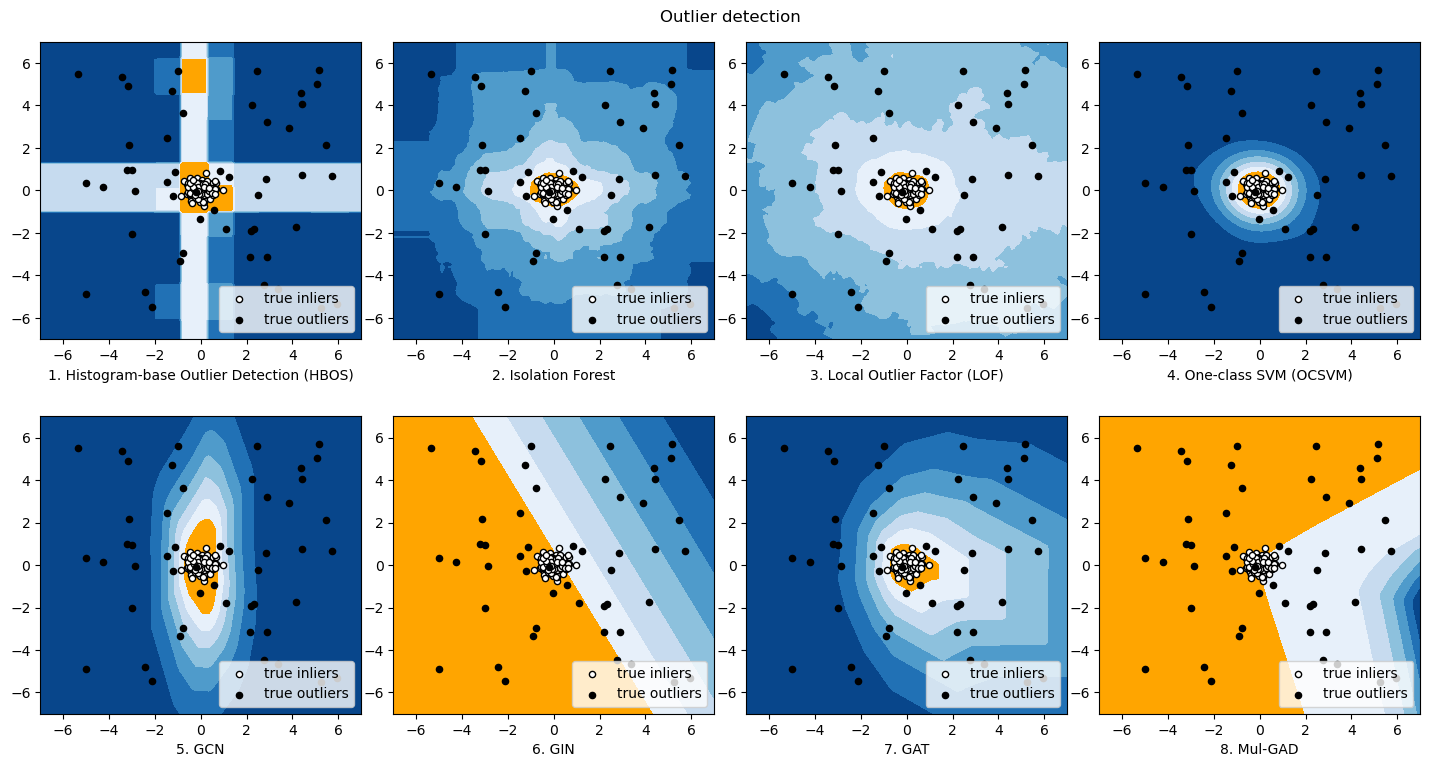

In [9]:
from dataset import pyg_dataset
from pyod.models.hbos import HBOS
graph = pyg_dataset(dataset_name="books", dataset_spilt=[0.064,0.3,0.3]).dataset
model = HBOS()
model.fit(graph.x[graph.train_mask])

test_auc = roc_auc_score(graph.y[graph.test_mask], y_test_scores)

In [361]:
# load the dataset
graph = pyg_dataset(dataset_name="cora", dataset_spilt=[0.064,0.3,0.3], anomaly_type="min").dataset
dgl_graph = pyg_to_dgl(graph)

# train_normal mask and train_anomaly mask
train_anomaly = [bool(graph.y[i] & graph.train_mask[i]) for i in range(len(graph.train_mask))] 
train_normal = [bool((~graph.y[i]) & graph.train_mask[i]) for i in range(len(graph.train_mask))]
val_anomaly = [bool(graph.y[i] & graph.val_mask[i]) for i in range(len(graph.val_mask))]
val_normal = [bool((~graph.y[i]) & graph.val_mask[i]) for i in range(len(graph.val_mask))]
test_anomaly = [bool(graph.y[i] & graph.test_mask[i]) for i in range(len(graph.test_mask))]
test_normal = [bool((~graph.y[i]) & graph.test_mask[i]) for i in range(len(graph.test_mask))]

g:\AI Learning\Mul-Graph_baseline\dataset.py:100: UserWarning: Anomaly is min class of dataset and anomaly rate is not conformed to setting
  warnings.warn(f"Anomaly is min class of dataset and anomaly rate is not conformed to setting")
F:\anaconda\envs\pygod2\lib\site-packages\dgl\heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [217]:
features = graph.x
edge_index = graph.edge_index
true_label = graph.y
node_features = graph.num_node_features
AUC_regularizer = 1
n_embedding = 32
hiddle_dim = 32
hiddle_layer = 2

model = SVDD(input_dim = node_features, hiddle_dim=hiddle_dim, number_class= n_embedding, hiddle_layer= hiddle_layer, dropout=0.5)
lr = 1e-2
epochs = 50
weight_decay = 5e-4
optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
early_stopping = EarlyStopping(patience = 20)


In [221]:
# trainning
for epoch in range(epochs):
    start = time.time()
    model.train()
    node_embedding = model(dgl_graph,features)
    if epoch % 10 == 0:
        center = model(dgl_graph, features)[train_normal].detach().mean(0)
    
    loss_train = objecttive_loss(node_embedding[train_anomaly], node_embedding[train_normal], center, AUC_regularizer)
    model.zero_grad()
    loss_train.backward()
    optimizer.step()

    model.eval()
    node_embedding = model(dgl_graph, features)

    loss_val = objecttive_loss(node_embedding[val_anomaly], node_embedding[val_normal], center, AUC_regularizer)
    val_anomaly_score = [anomaly_score(embedding, center) for embedding in node_embedding[graph.val_mask].cpu().detach()]
    auc = roc_auc_score(graph.y[graph.val_mask], val_anomaly_score)
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {}'.format(loss_train.item()),
          'loss_val: {}'.format(loss_val.item()),
          'roc_auc: {:.4f}'.format(auc),
          'time: {:.4f}s'.format(time.time() - start))    
    early_stopping(loss_val, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch: 0001 loss_train: -0.4991134703159332 loss_val: -0.49394768476486206 roc_auc: 0.5978 time: 0.2763s
EarlyStopping counter: 1 out of 20
Epoch: 0002 loss_train: -0.49533024430274963 loss_val: -0.4989123046398163 roc_auc: 0.6643 time: 0.5230s
Epoch: 0003 loss_train: -0.5002880096435547 loss_val: -0.49801501631736755 roc_auc: 0.4931 time: 0.1616s
EarlyStopping counter: 1 out of 20
Epoch: 0004 loss_train: -0.5000959038734436 loss_val: -0.49885308742523193 roc_auc: 0.7487 time: 0.1822s
EarlyStopping counter: 2 out of 20
Epoch: 0005 loss_train: -0.5035908818244934 loss_val: -0.4991309940814972 roc_auc: 0.9104 time: 0.1583s
Epoch: 0006 loss_train: -0.5061190724372864 loss_val: -0.498595267534256 roc_auc: 0.9063 time: 0.1645s
EarlyStopping counter: 1 out of 20
Epoch: 0007 loss_train: -0.5086079835891724 loss_val: -0.4986422657966614 roc_auc: 0.9176 time: 0.1633s
EarlyStopping counter: 2 out of 20
Epoch: 0008 loss_train: -0.5116948485374451 loss_val: -0.49955451488494873 roc_auc: 0.9324 tim

In [222]:
test_anomaly_score = [anomaly_score(embedding, center) for embedding in node_embedding[graph.test_mask].cpu().detach()]
auc = roc_auc_score(graph.y[graph.test_mask], test_anomaly_score)

print(f"Test Auc: {auc}")

test_anomaly_score = [anomaly_score(embedding, center) for embedding in node_embedding[graph.val_mask].cpu().detach()]
auc = roc_auc_score(graph.y[graph.val_mask], test_anomaly_score)

print(f"Val Auc: {auc}")

Test Auc: 0.9038879440665154


In [9]:
from label_SVDD_model import label_SVDD

# load the dataset
# graph = pyg_dataset(dataset_name="citeseer", dataset_spilt=[0.1,0.2,0.2], anomaly_type="min").dataset
graph = pyg_dataset(dataset_name="reddit", dataset_spilt=[0.2,0.2,0.2]).dataset
dgl_graph = pyg_to_dgl(graph)

# train_normal mask and train_anomaly mask
train_anomaly = [bool(graph.y[i] & graph.train_mask[i]) for i in range(len(graph.train_mask))] 
train_normal = [bool((~graph.y[i]) & graph.train_mask[i]) for i in range(len(graph.train_mask))]
val_anomaly = [bool(graph.y[i] & graph.val_mask[i]) for i in range(len(graph.val_mask))]
val_normal = [bool((~graph.y[i]) & graph.val_mask[i]) for i in range(len(graph.val_mask))]
test_anomaly = [bool(graph.y[i] & graph.test_mask[i]) for i in range(len(graph.test_mask))]
test_normal = [bool((~graph.y[i]) & graph.test_mask[i]) for i in range(len(graph.test_mask))]

features = graph.x
edge_index = graph.edge_index
true_label = graph.y
node_features = graph.num_node_features
AUC_regularizer = 1
n_embedding = 32
hiddle_dim = 32
hiddle_layer = 2
number_class = 2
label_svdd_balance = 1

model = label_SVDD(input_dim = node_features, hiddle_dim=hiddle_dim, embedding_dim=n_embedding, number_class=number_class, hiddle_layer= hiddle_layer, dropout=0.5)
lr = 1e-2
epochs = 50
weight_decay = 5e-4
optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
early_stopping1 = EarlyStopping(patience = 20)
early_stopping2 = EarlyStopping(patience = 20)
early_stopping3 = EarlyStopping(patience = 20)

g:\AI Learning\Mul-Graph_baseline\dataset.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dataset = Data(x=temp.x, edge_index=temp.edge_index,y=torch.tensor(temp.y, dtype=torch.long),train_mask=position,val_mask=position,test_mask=position)
g:\AI Learning\Mul-Graph_baseline\dataset.py:108: UserWarning: Anomaly is organic and anomaly rate is not conformed to setting
  warnings.warn(f"Anomaly is organic and anomaly rate is not conformed to setting")
F:\anaconda\envs\pygod2\lib\site-packages\dgl\heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [10]:
from torch.functional import F
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# trainning
for epoch in range(epochs):
    start = time.time()
    model.train()
    node_embedding, logits = model(dgl_graph,features)
    if epoch % 10 == 0:
        center = model(dgl_graph, features)[0][train_normal].detach().mean(0)
    loss_train = objecttive_loss(node_embedding[train_anomaly], node_embedding[train_normal], center, AUC_regularizer)
    model.zero_grad()
    loss_train.backward()
    optimizer.step()

    model.eval()
    node_embedding, logits = model(dgl_graph, features)

    loss_val = objecttive_loss(node_embedding[val_anomaly], node_embedding[val_normal], center, AUC_regularizer)
    val_anomaly_score = [anomaly_score(embedding, center) for embedding in node_embedding[graph.val_mask].cpu().detach()]
    auc = roc_auc_score(graph.y[graph.val_mask], val_anomaly_score)
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {}'.format(loss_train.item()),
          'loss_val: {}'.format(loss_val.item()),
          'roc_auc: {:.4f}'.format(auc),
          'time: {:.4f}s'.format(time.time() - start))    
    early_stopping1(loss_val, model)
    if early_stopping1.early_stop:
        print("Early stopping")
        break

# for epoch in range(epochs):
#     start = time.time()
#     model.train()
#     node_embedding, logits = model(dgl_graph,features)
#     if epoch % 10 == 0:
#         center = model(dgl_graph, features)[0][train_normal].detach().mean(0)
#     # SVDD loss function
#     loss_train = F.cross_entropy(logits[graph.train_mask],graph.y[graph.train_mask],weight=torch.tensor([1.0, 14.5]))
#     model.zero_grad()
#     loss_train.backward()
#     optimizer.step()

#     model.eval()
#     node_embedding, logits = model(dgl_graph, features)

#     loss_val = F.cross_entropy(logits[graph.val_mask],graph.y[graph.val_mask],weight=torch.tensor([1.0, 14.5]))
#     auc_label = roc_auc_score(graph.y[graph.val_mask].detach().numpy(),logits[graph.val_mask][:,1].detach().numpy())

#     val_anomaly_score = [anomaly_score(embedding, center) for embedding in node_embedding[graph.val_mask].cpu().detach()]
#     auc_svdd = roc_auc_score(graph.y[graph.val_mask], val_anomaly_score)
    
#     print('Epoch: {:04d}'.format(epoch+1),
#           'loss_train: {}'.format(loss_train.item()),
#           'loss_val: {}'.format(loss_val.item()),
#           'roc_auc_label: {:.4f}'.format(auc_label),
#           'roc_auc_svdd: {:.4f}'.format(auc_svdd),
#           'time: {:.4f}s'.format(time.time() - start))    
#     early_stopping2(loss_val, model)
#     if early_stopping2.early_stop:
#         print("Early stopping")
#         break

# for epoch in range(epochs):
#     start = time.time()
#     model.train()
#     node_embedding, logits = model(dgl_graph,features)
#     if epoch % 10 == 0:
#         center = model(dgl_graph, features)[0][train_normal].detach().mean(0)

#     # SVDD loss function
#     loss_svdd = objecttive_loss(node_embedding[train_anomaly], node_embedding[train_normal], center, AUC_regularizer)
#     loss_label = F.cross_entropy(logits[graph.train_mask],graph.y[graph.train_mask],weight=torch.tensor([1.0, 7]))
#     loss_train = loss_svdd + label_svdd_balance * loss_label
#     model.zero_grad()
#     loss_train.backward()
#     optimizer.step()

#     model.eval()
#     node_embedding, logits = model(dgl_graph, features)

#     loss_label = F.cross_entropy(logits[graph.val_mask],graph.y[graph.val_mask],weight=torch.tensor([1.0, 7]))
#     loss_svdd = objecttive_loss(node_embedding[train_anomaly], node_embedding[train_normal], center, AUC_regularizer)
#     loss_val = loss_svdd + loss_label
    
#     auc_label = roc_auc_score(graph.y[graph.val_mask].detach().numpy(),logits[graph.val_mask][:,1].detach().numpy())
#     val_anomaly_score = [anomaly_score(embedding, center) for embedding in node_embedding[graph.val_mask].cpu().detach()]
#     auc_svdd = roc_auc_score(graph.y[graph.val_mask], val_anomaly_score)
    
#     print('Epoch: {:04d}'.format(epoch+1),
#           'loss_train: {}'.format(loss_train.item()),
#           'loss_val: {}'.format(loss_val.item()),
#           'roc_auc_label: {:.4f}'.format(auc_label),
#           'roc_auc_svdd: {:.4f}'.format(auc_svdd),
#           'time: {:.4f}s'.format(time.time() - start))    
#     early_stopping3(loss_val, model)
#     if early_stopping3.early_stop:
#         print("Early stopping")
#         break

Epoch: 0001 loss_train: -0.49779295921325684 loss_val: -0.4875163435935974 roc_auc: 0.4837 time: 0.9552s
Epoch: 0002 loss_train: -0.48815345764160156 loss_val: -0.49781185388565063 roc_auc: 0.5813 time: 1.0550s
Epoch: 0003 loss_train: -0.49753686785697937 loss_val: -0.496715247631073 roc_auc: 0.5293 time: 1.0915s
EarlyStopping counter: 1 out of 20
Epoch: 0004 loss_train: -0.4964378774166107 loss_val: -0.4958604872226715 roc_auc: 0.5133 time: 0.9278s
EarlyStopping counter: 2 out of 20
Epoch: 0005 loss_train: -0.49571889638900757 loss_val: -0.4973612427711487 roc_auc: 0.5083 time: 0.9538s
EarlyStopping counter: 3 out of 20
Epoch: 0006 loss_train: -0.49690282344818115 loss_val: -0.4983936846256256 roc_auc: 0.5010 time: 0.9993s
Epoch: 0007 loss_train: -0.49823835492134094 loss_val: -0.49883249402046204 roc_auc: 0.5543 time: 0.8781s
Epoch: 0008 loss_train: -0.49871698021888733 loss_val: -0.4991220533847809 roc_auc: 0.5455 time: 0.8664s
Epoch: 0009 loss_train: -0.4991081953048706 loss_val: -

In [12]:
node_embedding, logits = model(dgl_graph,features)

test_anomaly_score = [anomaly_score(embedding, center) for embedding in node_embedding[graph.test_mask].cpu().detach()]
auc_svdd = roc_auc_score(graph.y[graph.test_mask], test_anomaly_score)

print(f"Test svdd_Auc: {auc_svdd}")

val_anomaly_score = [anomaly_score(embedding, center) for embedding in node_embedding[graph.val_mask].cpu().detach()]
auc_svdd = roc_auc_score(graph.y[graph.val_mask], val_anomaly_score)

print(f"Val svdd_Auc: {auc_svdd}\n")

auc_label = roc_auc_score(graph.y[graph.test_mask].detach().numpy(),logits[graph.test_mask][:,0].detach().numpy())
print(f"Test label_Auc: {auc_label}")

auc_label = roc_auc_score(graph.y[graph.val_mask].detach().numpy(),logits[graph.val_mask][:,0].detach().numpy())
print(f"Val label_Auc: {auc_label}\n")


auc_label_svdd = roc_auc_score(graph.y[graph.test_mask].detach().numpy(), normalize(logits[graph.test_mask][:,1].detach().numpy())  + normalize(test_anomaly_score))
print(f"Test label_svdd_Auc: {auc_label_svdd}")

auc_label_svdd = roc_auc_score(graph.y[graph.val_mask].detach().numpy(), normalize(logits[graph.val_mask][:,1].detach().numpy()) + normalize(val_anomaly_score))
print(f"Val label_svdd_Auc: {auc_label_svdd}")

Test svdd_Auc: 0.5614562396089233
Val svdd_Auc: 0.5340128005769275

Test label_Auc: 0.607921412441996
Val label_Auc: 0.5534333941811462

Test label_svdd_Auc: 0.4578122285912802
Val label_svdd_Auc: 0.5028790029973181


## 测试 BWGNN 与 DOMINANT 的数据融合效果

Expected: 能达到BWGNN的性能，同时能利用DOMINANT的表征，对syn异常也有很好的表现

1. **设计实验，判断DOMINANT的表征，训练一个二分类网络，判断效果如何**

In [263]:
from pygod.models import DOMINANT
from dataset import pyg_dataset, pyg_to_dgl

data = pyg_dataset(dataset_name="cora", dataset_spilt=[0.4,0.2,0.2], anomaly_type="syn", anomaly_ratio=0.1).dataset
# data = pyg_dataset(dataset_name="cora", dataset_spilt=[0.4,0.2,0.2], anomaly_type="min").dataset
model = DOMINANT(verbose=True, gpu=-1, epoch=10, lr=1e-3)
model = model.fit(data)

from torch_geometric.utils import to_dense_adj
x_, s_, hid_dominate = model.model(data.x, data.edge_index)
s = to_dense_adj(data.edge_index)[0]
score = model.loss_func(data.x,x_,s,s_)
score = score.detach().cpu().numpy()

from sklearn.metrics import roc_auc_score

outlier_scores = model.decision_function(data)
print(f'Raw scores: {outlier_scores}')
auc_score = roc_auc_score(data.y.numpy(), outlier_scores)
my_score = roc_auc_score(data.y.numpy(), score)
print('AUC Score:', auc_score)
print('AUC My Score:', my_score)

anomaly syntheic is on processing
using 0.08 seconds
Epoch 0000: Loss 0.5380
Epoch 0001: Loss 0.5364
Epoch 0002: Loss 0.5346
Epoch 0003: Loss 0.5337
Epoch 0004: Loss 0.5334
Epoch 0005: Loss 0.5333
Epoch 0006: Loss 0.5329
Epoch 0007: Loss 0.5326
Epoch 0008: Loss 0.5322
Epoch 0009: Loss 0.5320
Raw scores: [0.55513704 0.44958687 0.54521406 ... 0.3541517  0.54282665 0.55279076]
AUC Score: 0.94759867558353
AUC My Score: 0.94759867558353


### DOMINANT 表征数据获取

### BWGNN 表征数据获取

In [264]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from dataset import pyg_dataset, pyg_to_dgl
from early_stop import EarlyStopping
from sklearn.metrics import roc_auc_score
from BWGNN_model import BWGNN_em

data = pyg_dataset(dataset_name="cora", dataset_spilt=[0.4,0.3,0.25], anomaly_type="syn", anomaly_ratio=0.1).dataset
# data = pyg_dataset(dataset_name="cora", dataset_spilt=[0.4,0.3,0.25], anomaly_type="min").dataset
dgl_data = pyg_to_dgl(data)
number_class = 2
hid_dim = 64
number_class = 2
BWGNN_model = BWGNN_em(data.x.shape[1], 64, number_class, dgl_data)

optimizer = Adam(BWGNN_model.parameters(), lr = 1e-4)
epochs = 300
early_stop = EarlyStopping(patience=20)

for epoch in range(epochs):
    BWGNN_model.train()
    logits, BW_hid = BWGNN_model(data.x)
    train_loss = cross_entropy(logits[data.train_mask], data.y[data.train_mask], weight=torch.tensor([1.0, 10.0]))
    BWGNN_model.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    BWGNN_model.eval()
    logits, BW_hid= BWGNN_model(data.x)
    val_loss = cross_entropy(logits[data.val_mask], data.y[data.val_mask], weight=torch.tensor([1.0, 10.0]))
    probs = logits.softmax(1)
    auc = roc_auc_score(data.y[data.val_mask].numpy(), probs[data.val_mask][:,1].detach().numpy())

    early_stop(val_loss, BWGNN_model)
    if early_stop.early_stop == True:
        print ("Early stopping")
        break
    print (f"Epoch {epoch+1}/{epochs}: loss: {train_loss}, auc: {auc}")
BWGNN_model.eval()
logits, BW_hid= BWGNN_model(data.x)
probs = logits.softmax(1)
auc = roc_auc_score(data.y[data.test_mask].numpy(), probs[data.test_mask][:,1].detach().numpy())
print (f"Auc: {auc}")

anomaly syntheic is on processing
using 0.09 seconds
Epoch 1/300: loss: 0.6900728344917297, auc: 0.721964782205746
Epoch 2/300: loss: 0.6899038553237915, auc: 0.7219750798064052
Epoch 3/300: loss: 0.6897387504577637, auc: 0.7219647822057461
Epoch 4/300: loss: 0.6895783543586731, auc: 0.7220059726083823
Epoch 5/300: loss: 0.6894214749336243, auc: 0.7220162702090412
Epoch 6/300: loss: 0.6892673969268799, auc: 0.7216764493872929
Epoch 7/300: loss: 0.6891182065010071, auc: 0.721511687776748
Epoch 8/300: loss: 0.6889744997024536, auc: 0.7212027597569767
Epoch 9/300: loss: 0.688834011554718, auc: 0.7211409741530225
Epoch 10/300: loss: 0.6886962056159973, auc: 0.7209762125424777
Epoch 11/300: loss: 0.688559889793396, auc: 0.7208320461332509
Epoch 12/300: loss: 0.6884261965751648, auc: 0.7207496653279785
Epoch 13/300: loss: 0.6882947683334351, auc: 0.7205849037174339
Epoch 14/300: loss: 0.6881651878356934, auc: 0.7206672845227061
Epoch 15/300: loss: 0.688037633895874, auc: 0.7206260941200701
E

### 两层 GAT，获取其表征

In [265]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn.functional import cross_entropy
from dataset import pyg_dataset, pyg_to_dgl
from early_stop import EarlyStopping
from sklearn.metrics import roc_auc_score
from torch_geometric.nn.conv import GATConv, GCNConv, MessagePassing

class GAT(nn.Module):

    def __init__(self, in_dim, hid_dim, out_dim):
        super(GAT, self).__init__()
        self.conv1 = GCNConv(in_channels=in_dim, out_channels=hid_dim)
        self.conv2 = GCNConv(in_channels=hid_dim, out_channels=out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        h = F.dropout(F.relu(x), 0.3, self.training)
        x = self.conv2(h, edge_index)
        return x, h

data = pyg_dataset(dataset_name="cora", dataset_spilt=[0.4,0.3,0.25], anomaly_type="syn", anomaly_ratio=0.1).dataset
# data = pyg_dataset(dataset_name="cora", dataset_spilt=[0.4,0.3,0.25], anomaly_type="min").dataset
dgl_data = pyg_to_dgl(data)
number_class = 2
hid_dim = 64
number_class = 2
edge_index = data.edge_index
GAT_model = GAT(data.x.shape[1], 64, number_class)

optimizer = Adam(GAT_model.parameters(), lr = 1e-3)
epochs = 300
early_stop = EarlyStopping(patience=20)

for epoch in range(epochs):
    GAT_model.train()
    logits, GAT_hid = GAT_model(data.x, edge_index)
    train_loss = cross_entropy(logits[data.train_mask], data.y[data.train_mask], weight=torch.tensor([1.0, 10.0]))
    GAT_model.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    GAT_model.eval()
    logits, GAT_hid= GAT_model(data.x, edge_index)
    val_loss = cross_entropy(logits[data.val_mask], data.y[data.val_mask], weight=torch.tensor([1.0, 10.0]))
    probs = logits.softmax(1)
    auc = roc_auc_score(data.y[data.val_mask].numpy(), probs[data.val_mask][:,1].detach().numpy())

    early_stop(val_loss, GAT_model)
    if early_stop.early_stop == True:
        print ("Early stopping")
        break
    print (f"Epoch {epoch+1}/{epochs}: loss: {train_loss}, auc: {auc}")
GAT_model.eval()
logits, GAT_hid= GAT_model(data.x, edge_index)
probs = logits.softmax(1)
auc = roc_auc_score(data.y[data.test_mask].numpy(), probs[data.test_mask][:,1].detach().numpy())
print (f"Auc: {auc}")

anomaly syntheic is on processing
using 0.08 seconds
Epoch 1/300: loss: 0.6930190920829773, auc: 0.6255411255411256
Epoch 2/300: loss: 0.6923465728759766, auc: 0.680952380952381
Epoch 3/300: loss: 0.6916289329528809, auc: 0.7054951850870219
Epoch 4/300: loss: 0.6911395788192749, auc: 0.7191801395883028
Epoch 5/300: loss: 0.690441906452179, auc: 0.729039667815178
Epoch 6/300: loss: 0.6896844506263733, auc: 0.73551550490326
Epoch 7/300: loss: 0.6889178156852722, auc: 0.7387401713932324
Epoch 8/300: loss: 0.6880950927734375, auc: 0.7414170863150455
Epoch 9/300: loss: 0.6874065399169922, auc: 0.7438731336690521
Epoch 10/300: loss: 0.6862128973007202, auc: 0.7452866861030126
Epoch 11/300: loss: 0.6855784058570862, auc: 0.7462938422122096
Epoch 12/300: loss: 0.6845324039459229, auc: 0.7469122714020675
Epoch 13/300: loss: 0.684036910533905, auc: 0.7471419736725858
Epoch 14/300: loss: 0.682813286781311, auc: 0.7476720558353211
Epoch 15/300: loss: 0.6814088225364685, auc: 0.7478664192949906
Epo

### 消除冗余特征函数

### 消除不同任务表征量纲的影响，归一化融合的嵌入矩阵

In [227]:
def cosine_distance(x1, x2=None, eps=1e-8):
    x2 = x1 if x2 is None else x2
    w1 = x1.norm(p=2, dim=1, keepdim=True)
    w2 = w1 if x2 is x1 else x2.norm(p=2, dim=1, keepdim=True)
    # .clamp(min=eps)
    # 0-1
    return (torch.mm(x1, x2.t()) / (w1 * w2.t()).clamp(min=eps)).absolute()

# 越无关，权重越大
def zero2one(feature):
    """Input: feature must be a 1d numpy array
    """
    # feature = np.array(feature)
    min = feature.min()
    max = feature.max()
    return (feature - min)/(max-min)

def feature_normalize(feature, axis=1, eps=1e-10):
    """2D array feature to row normalize"""
    mean = None
    std = None
    if axis == 1:
        mean = feature.mean(axis=axis).reshape(-1,1)
        std = feature.std(axis=axis).reshape(-1,1)
    elif axis == 0:
        mean = feature.mean(axis=axis).reshape(1,-1)
        std = feature.std(axis=axis).reshape(1,-1)
    return (feature - mean) / (std + eps)

# hiddle = hid_dominate.detach()
# hiddle = BW_hid.detach()
# hiddle = GAT_hid.detach()
# 融合的特征未曾归一化

# 补充信息最好策略
hiddle = torch.concat((1 * feature_normalize(GAT_hid.detach(),axis=0), 1 * feature_normalize(BW_hid.detach(),axis=0), 0.2 * feature_normalize(hid_dominate.detach(),axis=0)), axis=1)

# 可学习化的参数
# l_weight = [nn.Parameter(torch.randn([hiddle.shape[-1]], dtype=torch.float32, requires_grad=True))]
# hiddle = torch.mul(hiddle, torch.softmax(*l_weight, dim = 0))
# optimizer_ = Adam(l_weight, lr = 1e-3)

# 计算hiddle特征之间的相似度，放缩到0-1之间 （专家系统）
# hiddle = zero2one((1-cosine_distance(hiddle.T)).mean(axis=0))*hiddle

### 标签导向，检测融合的嵌入矩阵

In [314]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn.functional import cross_entropy
# from dgl.nn import GraphConv
from torch_geometric.nn import GCNConv
from early_stop import EarlyStopping
from sklearn.metrics import roc_auc_score

number_class = 2
linear_model = GCNConv(hiddle.shape[1], number_class) 
optimizer = Adam(linear_model.parameters(),lr = 1e-3)
epochs = 2000
early_stop = EarlyStopping(patience=20)

for epoch in range(epochs):
    linear_model.train()
    logits = linear_model(hiddle, data.edge_index)
    train_loss = cross_entropy(logits[data.train_mask], data.y[data.train_mask], weight=torch.tensor([1.0, 10]))
    linear_model.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    linear_model.eval()
    logits = linear_model(hiddle, data.edge_index)
    val_loss = cross_entropy(logits[data.val_mask], data.y[data.val_mask], weight=torch.tensor([1.0, 10]))
    probs = logits.softmax(1)
    auc = roc_auc_score(data.y[data.val_mask].numpy(), probs[data.val_mask][:,1].detach().numpy())
    
    early_stop(val_loss, linear_model)
    if early_stop.early_stop == True:
        print ("Early stopping")
        break
    print (f"Epoch {epoch+1}/{epochs}: loss: {train_loss}, auc: {auc}")

linear_model.eval()
logits = linear_model(hiddle, data.edge_index)
probs = logits.softmax(1)
auc = roc_auc_score(data.y[data.test_mask].numpy(), probs[data.test_mask][:,1].detach().numpy())
print (f"Test Auc: {auc}")

Epoch 1/2000: loss: 0.7500657439231873, auc: 0.46432712375357504
Epoch 2/2000: loss: 0.7401655912399292, auc: 0.5405941614490738
Epoch 3/2000: loss: 0.7304065227508545, auc: 0.6193347246914536
Epoch 4/2000: loss: 0.7207922339439392, auc: 0.6925098554533509
Epoch 5/2000: loss: 0.7113261818885803, auc: 0.7547860142743037
Epoch 6/2000: loss: 0.702012300491333, auc: 0.8108525933369405
Epoch 7/2000: loss: 0.6928532719612122, auc: 0.8542681198629254
Epoch 8/2000: loss: 0.6838525533676147, auc: 0.887763778310273
Epoch 9/2000: loss: 0.6750122904777527, auc: 0.9125505655613099
Epoch 10/2000: loss: 0.6663348078727722, auc: 0.9306897529051041
Epoch 11/2000: loss: 0.6578222513198853, auc: 0.942207106232769
Epoch 12/2000: loss: 0.6494759917259216, auc: 0.9509675092113061
Epoch 13/2000: loss: 0.6412971019744873, auc: 0.9567133029295818
Epoch 14/2000: loss: 0.6332863569259644, auc: 0.9607327819432636
Epoch 15/2000: loss: 0.6254439353942871, auc: 0.9632836051634845
Epoch 16/2000: loss: 0.6177700161933

### 重构损失导向，检测融合嵌入矩阵

In [31]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn.functional import cross_entropy
# from dgl.nn import GraphConv
# from torch_geometric.nn import GCNConv
from early_stop import EarlyStopping
from sklearn.metrics import roc_auc_score
from pygod.models.basic_nn import GCN


class DOMINANT_recon(nn.Module):
    def __init__(self,
                 in_dim,
                 hid_dim,
                 out_dim,
                 decoder_layers,
                 dropout,
                 act):
        super(DOMINANT_recon, self).__init__()

        # split the number of layers for the encoder and decoders

        self.attr_decoder = GCN(in_channels=in_dim,
                                hidden_channels=hid_dim,
                                num_layers=decoder_layers,
                                out_channels=out_dim,
                                dropout=dropout,
                                act=act)

        self.struct_decoder = GCN(in_channels=in_dim,
                                  hidden_channels=hid_dim,
                                  num_layers=decoder_layers,
                                  out_channels=out_dim,
                                  dropout=dropout,
                                  act=act)

    def forward(self, h, edge_index):
        # decode feature matrix
        x_ = self.attr_decoder(h, edge_index)
        # print (x_.shape)
        # decode adjacency matrix
        h_ = self.struct_decoder(h, edge_index)
        # print (h_.shape)
        s_ = h_ @ h_.T
        # return reconstructed matrices
        return x_, s_, h



In [255]:
# hiddle = hid_dominate.detach()
# hiddle = BW_hid.detach()
# hiddle = GAT_hid.detach()
# 融合的特征未曾归一化

# 补充信息最好策略
hiddle = torch.concat((1 * feature_normalize(GAT_hid.detach(),axis=0), 1 * feature_normalize(BW_hid.detach(),axis=0), 0.2 * feature_normalize(hid_dominate.detach(),axis=0)), axis=1)

# 可学习化的参数
# l_weight = [nn.Parameter(torch.randn([hiddle.shape[-1]], dtype=torch.float32, requires_grad=True))]
# hiddle = torch.mul(hiddle, torch.softmax(*l_weight, dim = 0))
# optimizer_ = Adam(l_weight, lr = 1e-3)

# 计算hiddle特征之间的相似度，放缩到0-1之间 （专家系统）
# hiddle = zero2one((1-cosine_distance(hiddle.T)).mean(axis=0))*hiddle

In [274]:
import torch.nn.functional as F

hid_dim = 32
decode_layer = 1
# domin_recon_model = DOMINANT_recon(hiddle.shape[1], hid_dim, data.x.shape[1], decode_layer, dropout=0.3, act= F.relu)
domin_recon_model = DOMINANT_recon(hiddle.shape[1], data.x.shape[1], data.x.shape[1], decode_layer, dropout=0.3, act= F.relu)

optimizer = Adam(domin_recon_model.parameters(), lr = 5e-3, weight_decay=5e-4)
epochs = 100
early_stop = EarlyStopping(patience=20)

from torch_geometric.utils import to_dense_adj
s = to_dense_adj(data.edge_index)[0]
alpha = torch.std(s).detach() / (torch.std(data.x).detach() + torch.std(s).detach())
print (f"Alpha: {alpha}")

# l_weight = [nn.Parameter(torch.tensor(zero2one((1-cosine_distance(hiddle.T)).sum(axis=0))*20, dtype=torch.float32, requires_grad=True))]
# l_weight = [nn.Parameter(torch.randn([hiddle.shape[-1]], dtype=torch.float32, requires_grad=True))]
l_weight = [nn.Parameter(torch.ones([hiddle.shape[-1]], dtype=torch.float32, requires_grad=True))]
b_weight = [nn.Parameter(torch.ones([3], dtype=torch.float32, requires_grad=True))]

optimizer_ = Adam(l_weight, lr = 5e-2, weight_decay=5e-2)
optimizer_b = Adam(b_weight, lr = 1e-1, weight_decay=5e-2)
print (l_weight)
def reco_loss_func(x, x_, s, s_):
    # attribute reconstruction loss
    diff_attribute = torch.pow(x - x_, 2)
    attribute_errors = torch.sqrt(torch.sum(diff_attribute, 1))

    # structure reconstruction loss
    diff_structure = torch.pow(s - s_, 2)
    structure_errors = torch.sqrt(torch.sum(diff_structure, 1))

    score = alpha * attribute_errors \
            + (1 - alpha) * structure_errors
    return score

for epoch in range(epochs):
    hiddle = torch.concat((b_weight[0][0] * feature_normalize(GAT_hid.detach(),axis=0), b_weight[0][1] * feature_normalize(BW_hid.detach(),axis=0), b_weight[0][2] * feature_normalize(hid_dominate.detach(),axis=0)), axis=1)
    # hiddle = zero2one((1-cosine_distance(hiddle.T)).mean(axis=0))*hiddle
    hiddle_ = torch.mul(hiddle, hiddle.shape[1]*torch.softmax(*l_weight, dim = 0))
    # hiddle_ = torch.mul(hiddle, *l_weight)

    domin_recon_model.train()
    x_, s_, hid  = domin_recon_model(hiddle_, data.edge_index)
    
    nodes_loss = reco_loss_func(data.x, x_, s, s_)
    train_loss = nodes_loss.mean()
    nodes_loss_numpy = nodes_loss.detach().numpy()

    optimizer.zero_grad()
    optimizer_.zero_grad()
    optimizer_b.zero_grad()
    train_loss.backward()
    optimizer.step()
    optimizer_.step()
    optimizer_b.step()
    dropout_auc = roc_auc_score(data.y[data.test_mask].numpy(), nodes_loss_numpy[data.test_mask])
    
    early_stop(train_loss, domin_recon_model)
    if early_stop.early_stop == True:
        print ("Early stopping")
        break
    print (f"Epoch {epoch+1}/{epochs}: loss: {train_loss}, test_auc: {dropout_auc}")

Alpha: 0.8370133638381958
[Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)]
Epoch 1/100: loss: 561.194091796875, test_auc: 0.6760683760683761
Epoch 2

In [275]:
# print (hiddle.shape[1]*torch.softmax(*l_weight, dim = 0))
# hiddle = hid_dominate.detach()
# hiddle = BW_hid.detach()
print (b_weight)
print (torch.softmax(*b_weight, dim = 0))

[Parameter containing:
tensor([ 0.0080, -0.0008,  0.0118], requires_grad=True)]
tensor([0.3339, 0.3310, 0.3351], grad_fn=<SoftmaxBackward0>)


### 1. 标签导向与重构导向，先完成重构导向普遍性的实验

### 2. 特征包含无用，冗余以及互补信息。冗余与互补信息通过计算相似度矩阵完成；仍需完善对无用信息针对任务导向的舍弃（考虑通过网络自己学习）

### 3. 一个案例实现，完成三个视角的信息融合，实现在生成，最小类以及原生异常数据集上的通用，且性能不差于任何一个已经存在的SOTA

### 4. 一般化框架的构建，做出多组数据融合对比实验，实验做到这一步，基本就杀青了

* **考虑到，表征学习与重构损失是独立训练的。表征的获取必须完成其他方法的完整运行，如此进行融合学习未免南辕北辙了**

* **可以将表征学习与重构损失联合训练训练的。不能，一旦联合就变成 DOMINANTE 模型，任务上就不通用了**

In [21]:
import torch
import torch.nn as nn
from models.GAT_model import GAT
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from dataset import pyg_dataset, pyg_to_dgl
from early_stop import EarlyStopping
from models.BWGNN_model import BWGNN_em
from torch_geometric.utils import to_dense_adj
from sklearn.metrics import roc_auc_score
from pygod.models import DOMINANT
from dataset import pyg_dataset, pyg_to_dgl
from utils import anomaly_weight, train_for_GCN, feature_fusion

data = pyg_dataset(dataset_name="citeseer", dataset_spilt=[0.4,0.2,0.3], anomaly_type="min", anomaly_ratio=0.1).dataset
# data2 = pyg_dataset(dataset_name="cora", dataset_spilt=[0.4,0.2,0.3], anomaly_type="min", anomaly_ratio=0.1).dataset
dgl_data = pyg_to_dgl(data)
a_weight = anomaly_weight(data)

# data = pyg_dataset(dataset_name="cora", dataset_spilt=[0.4,0.2,0.2], anomaly_type="min").dataset
model = DOMINANT(verbose=True, gpu=-1, epoch=1, lr=1e-3)
model = model.fit(data)

x_, s_, hid_dom = model.model(data.x, data.edge_index)

s = to_dense_adj(data.edge_index)[0]
score = model.loss_func(data.x,x_,s,s_)
score = score.detach().cpu().numpy()
outlier_scores = model.decision_function(data)
test_auc_do = roc_auc_score(data.y[data.test_mask].numpy(), score[data.test_mask])
print('Final Test AUC:', test_auc_do)
print ("--------------------- The Embedding of Dominate have done!!! ------------------")


number_class = 2
hid_dim = 64
BWGNN_model = BWGNN_em(data.x.shape[1], 64, number_class, dgl_data)
BW_optimizer = Adam(BWGNN_model.parameters(), lr = 1e-4)
epochs = 100
hid_bw, test_auc_bw, best_auc_bw = train_for_GCN(BWGNN_model, BW_optimizer, data, a_weight, epochs)
print ("--------------------- The Embedding of BWGNN have done!!! ------------------")


hid_dim = 64
edge_index = data.edge_index
gat_model = GAT(data.x.shape[1], 64, number_class, data)
GAT_optimizer = Adam(gat_model.parameters(), lr = 1e-3)
epochs = 100
hid_gat, test_auc_gat, best_auc_gat = train_for_GCN(gat_model, GAT_optimizer, data, a_weight, epochs)
print ("--------------------- The Embedding of GAT have done!!! ------------------")


import torch.nn.functional as F
from pygod.models.basic_nn import GCN
from torch_geometric.utils import to_dense_adj
class DOMINANT_recon(nn.Module):
    def __init__(self,
                in_dim,
                hid_dim,
                out_dim,
                decoder_layers,
                dropout,
                act):
        super(DOMINANT_recon, self).__init__()

        # split the number of layers for the encoder and decoders
        self.attr_decoder = GCN(in_channels=in_dim,
                                hidden_channels=hid_dim,
                                num_layers=decoder_layers,
                                out_channels=out_dim,
                                dropout=dropout,
                                act=act)

        self.struct_decoder = GCN(in_channels=in_dim,
                                hidden_channels=hid_dim,
                                num_layers=decoder_layers,
                                out_channels=out_dim,
                                dropout=dropout,
                                act=act)

    def forward(self, h, edge_index):
        # decode feature matrix
        x_ = self.attr_decoder(h, edge_index)
        # print (x_.shape)
        # decode adjacency matrix
        h_ = self.struct_decoder(h, edge_index)
        # print (h_.shape)
        s_ = h_ @ h_.T
        # return reconstructed matrices
        return x_, s_, h

def reco_loss_func(x, x_, s, s_):
    # attribute reconstruction loss
    diff_attribute = torch.pow(x - x_, 2)
    attribute_errors = torch.sqrt(torch.sum(diff_attribute, 1))

    # structure reconstruction loss
    diff_structure = torch.pow(s - s_, 2)
    structure_errors = torch.sqrt(torch.sum(diff_structure, 1))

    score = alpha * attribute_errors \
            + (1 - alpha) * structure_errors
    return score

s = to_dense_adj(data.edge_index)[0]
alpha = torch.std(s).detach() / (torch.std(data.x).detach() + torch.std(s).detach())
print (f"Alpha: {alpha}")

Epoch 0000: Loss 0.3043
Final Test AUC: 0.4690079151617613
--------------------- The Embedding of Dominate have done!!! ------------------
Epoch 1/100: val_loss: 0.6960328221321106, val_auc: 0.48437074829931975
Epoch 2/100: val_loss: 0.6958662867546082, val_auc: 0.4855952380952381
Epoch 3/100: val_loss: 0.6957038044929504, val_auc: 0.4876020408163265
Epoch 4/100: val_loss: 0.6955432891845703, val_auc: 0.500297619047619
Epoch 5/100: val_loss: 0.6953902840614319, val_auc: 0.5039625850340136
Epoch 6/100: val_loss: 0.6952409744262695, val_auc: 0.5020918367346939
Epoch 7/100: val_loss: 0.6950961947441101, val_auc: 0.5043537414965987
Epoch 8/100: val_loss: 0.6949560046195984, val_auc: 0.5217687074829932
Epoch 9/100: val_loss: 0.6948179602622986, val_auc: 0.5336904761904762
Epoch 10/100: val_loss: 0.6946843862533569, val_auc: 0.5298554421768708
Epoch 11/100: val_loss: 0.6945534944534302, val_auc: 0.5292857142857144
Epoch 12/100: val_loss: 0.6944274306297302, val_auc: 0.5294387755102041
Epoch 

In [1]:
import torch
import numpy as np
import torch.nn as nn
from models.GAT_model import GAT
from models.GCN_model import GCN
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from dataset import pyg_dataset, pyg_to_dgl
from early_stop import EarlyStopping
from models.BWGNN_model import BWGNN_em
from torch_geometric.utils import to_dense_adj
from sklearn.metrics import roc_auc_score
from pygod.models import DOMINANT
from torch_geometric.nn.conv import GCNConv
from dataset import pyg_dataset, pyg_to_dgl
from utils import *

torch.manual_seed(21)
device = torch.device("cpu")

def train_for_mul_model(model_list, optimizer_list, linear_model, linear_optimizer, data, a_weight, epochs, b_weight, b_optimizer=None):
    """Train for multi model togeother. Like GAT, GCN, BWGNN or anyelse. 
    Args: 
        b_weight: option for numbers list or learnable parameters
        b_optimizer: None if b_weight is numbers list, real torch optimizer if b_weight belongs to the learnable parameters.
    """
    best_val_auc = 0
    early_stop = EarlyStopping(patience=20)
    for epoch in range(epochs):
        print (b_weight)
        hiddle_list = []
        for pos, model in enumerate(model_list):
            model.train()
            logits, hid = model(data.x)
            hid = hid * b_weight[0][pos]
            # if pos != 2:
                # hid = hid * 0
            hiddle_list.append(hid)
        # 特征融合以及特征学习
        hiddle = torch.concat(hiddle_list, axis=1)
        hiddle = zero2one((1-cosine_distance(hiddle.T)).mean(axis=0))*hiddle
        
        logits = linear_model(hiddle, data.edge_index)
        train_loss = cross_entropy(logits[data.train_mask], data.y[data.train_mask], weight=torch.tensor([1.0, a_weight],device=device))
        
        for optimizer in optimizer_list:
            optimizer.zero_grad()
        linear_optimizer.zero_grad()
        if b_optimizer != None:
            b_optimizer.zero_grad()
        
        train_loss.backward()
        
        for optimizer in optimizer_list:
            optimizer.step()
        linear_optimizer.step()
        if b_optimizer != None:
            b_optimizer.step()

        hiddle_list = []
        for model in model_list:
            model.eval()
            logits, hid = model(data.x)
            hiddle_list.append(hid)
        # 特征融合以及特征学习
        hiddle = torch.concat(hiddle_list, axis=1)
        logits = linear_model(hiddle, data.edge_index)

        val_loss = cross_entropy(logits[data.val_mask], data.y[data.val_mask], weight=torch.tensor([1.0, a_weight],device=device))
        probs = logits.softmax(1)
        
        auc = roc_auc_score(data.y[data.val_mask].cpu().numpy(), probs[data.val_mask][:,1].detach().cpu().numpy()) if data.y.is_cuda else \
             roc_auc_score(data.y[data.val_mask].numpy(), probs[data.val_mask][:,1].detach().numpy())
        
        if auc >= best_val_auc:
            best_val_auc = auc

        early_stop(val_loss, model)
        if early_stop.early_stop == True:
            print ("Early stopping")
            break
        print (f"Epoch {epoch+1}/{epochs}: val_loss: {val_loss}, val_auc: {auc}")
    hiddle_list = []
    for model in model_list:
        model.eval()
        logits, hid = model(data.x)
        hiddle_list.append(hid)
    # 特征融合以及特征学习
    hiddle = torch.concat(hiddle_list, axis=1)
    logits = linear_model(hiddle, data.edge_index)
    probs = logits.softmax(1)
    auc = roc_auc_score(data.y[data.test_mask].cpu().numpy(), probs[data.test_mask][:,1].detach().cpu().numpy()) if data.y.is_cuda else \
             roc_auc_score(data.y[data.test_mask].numpy(), probs[data.test_mask][:,1].detach().numpy())
    print (f"Final Test Auc: {auc}")
    return hid, auc, best_val_auc

def train_for_param(data_name):
    parameter_list = np.linspace(start=0,stop=1,num=1)
    param2performance_list = []
    for param1 in parameter_list:
        param2 = 1 - param1

        # run five times to get mean and std for test. best performance for val.
        run_times = 3
        test_auc_mean = []
        test_auc_std = []
        val_auc_best = []
        test_list = []
        val_list = []
        for i in range(run_times):
            np.random.seed(i*2)
            # data = pyg_dataset(dataset_name=data_name, dataset_spilt=[0.4,0.29,0.3]).dataset
            data = pyg_dataset(dataset_name=data_name, dataset_spilt=[0.4,0.29,0.3], anomaly_type="min").dataset
            # data2 = pyg_dataset(dataset_name="cora", dataset_spilt=[0.4,0.2,0.3], anomaly_type="min", anomaly_ratio=0.1).dataset
            dgl_data = pyg_to_dgl(data)
            data = data.to(device)
            dgl_data = dgl_data.to(device)

            a_weight = anomaly_weight(data)

            epochs = 75
            hid_dim = 64
            number_class = 2
            gcn_model = GCN(data.x.shape[1], hid_dim, number_class, data).to(device)
            gat_model = GAT(data.x.shape[1], hid_dim, number_class, data).to(device)
            bw_model = BWGNN_em(data.x.shape[1], hid_dim, number_class, dgl_data).to(device)
            model_list = [gcn_model, gat_model, bw_model]
            cla_model = GCNConv(hid_dim*len(model_list), number_class).to(device)

            # l_weight = [nn.Parameter(torch.ones([hid_dom.shape[-1] * feature_length], dtype=torch.float32, requires_grad=True))]
            # b_weight = [nn.Parameter(torch.ones([len(model_list)], dtype=torch.float32, requires_grad=True))]
            b_weight = [[0.0, param1, param2]]
            # b_optimizer = Adam(b_weight, lr = 1e-2, weight_decay=5e-2)
            # l_optimizer_ = Adam(l_weight, lr = 5e-2, weight_decay=5e-2)

            gcn_optimizer = Adam(gcn_model.parameters(), lr = 1e-3)
            gat_optimizer = Adam(gat_model.parameters(), lr = 1e-3)
            bw_optimizer = Adam(bw_model.parameters(), lr = 1e-3)
            cla_optimizer = Adam(cla_model.parameters(), lr = 1e-3)

            optimizer_list = [gcn_optimizer,gat_optimizer,bw_optimizer]    
            _, auc, best_val_auc = train_for_mul_model(model_list, optimizer_list, cla_model, cla_optimizer, data, a_weight, epochs, b_weight)
            
            test_list.append(auc)
            val_list.append(best_val_auc)
        
        test_auc_mean.append(np.array(test_list).mean())
        test_auc_std.append(np.array(test_list).std())
        val_auc_best.append(np.array(val_list).max())

        param2performance_list.append([param1, param2, test_auc_mean[-1], test_auc_std[-1], val_auc_best[-1]])
        print (test_list,f"\n Test mean: {np.array(test_list).mean()}",f"\n Test std: {np.array(test_list).std()}")
        print (val_list, f"\n Val best: {np.array(val_list).max()}")
        
    np.savetxt(f"./result/param2performance_{data_name}_gatbw.txt", np.array(param2performance_list))

dataset_ava_list = ["karate"]
for data_name in dataset_ava_list:
    train_for_param(data_name)
    

F:\anaconda\envs\pygod2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[0.0, 0.0, 1.0]]
Epoch 1/75: val_loss: 0.6857784986495972, val_auc: 0.875
[[0.0, 0.0, 1.0]]
Epoch 2/75: val_loss: 0.6829900145530701, val_auc: 0.875
[[0.0, 0.0, 1.0]]
Epoch 3/75: val_loss: 0.6806588768959045, val_auc: 0.9375
[[0.0, 0.0, 1.0]]
Epoch 4/75: val_loss: 0.678452730178833, val_auc: 0.9375
[[0.0, 0.0, 1.0]]
Epoch 5/75: val_loss: 0.6762498021125793, val_auc: 0.9375
[[0.0, 0.0, 1.0]]
Epoch 6/75: val_loss: 0.6741844415664673, val_auc: 0.9375
[[0.0, 0.0, 1.0]]
Epoch 7/75: val_loss: 0.6719791889190674, val_auc: 0.9375
[[0.0, 0.0, 1.0]]
Epoch 8/75: val_loss: 0.6694870591163635, val_auc: 0.9375
[[0.0, 0.0, 1.0]]
Epoch 9/75: val_loss: 0.6669013500213623, val_auc: 1.0
[[0.0, 0.0, 1.0]]
Epoch 10/75: val_loss: 0.6642493009567261, val_auc: 1.0
[[0.0, 0.0, 1.0]]
Epoch 11/75: val_loss: 0.6613300442695618, val_auc: 1.0
[[0.0, 0.0, 1.0]]
Epoch 12/75: val_loss: 0.6583888530731201, val_auc: 1.0
[[0.0, 0.0, 1.0]]
Epoch 13/75: val_loss: 0.6551105976104736, val_auc: 1.0
[[0.0, 0.0, 1.0]]
Epoch 14

### 如上是遍历参数空间
### 如下是使用自学习参数，对表征数据进行融合

In [2]:
run_times = 1
test_auc_mean = []
test_auc_std = []
val_auc_best = []
test_list = []
val_list = []
device = torch.device("cuda")
# param2performance_list = []
for i in range(run_times):
    np.random.seed(3)
    data = pyg_dataset(dataset_name="weibo", dataset_spilt=[0.4,0.29,0.3], anomaly_type="min").dataset
    # data2 = pyg_dataset(dataset_name="cora", dataset_spilt=[0.4,0.2,0.3], anomaly_type="min", anomaly_ratio=0.1).dataset
    dgl_data = pyg_to_dgl(data)
    a_weight = anomaly_weight(data)

    epochs = 10
    hid_dim = 64
    number_class = 2
    edge_index = data.edge_index
    gcn_model = GCN(data.x.shape[1], hid_dim, number_class, data)
    gat_model = GAT(data.x.shape[1], hid_dim, number_class, data)
    bw_model = BWGNN_em(data.x.shape[1], hid_dim, number_class, dgl_data)
    model_list = [gcn_model,gat_model,bw_model]
    cla_model = GCNConv(hid_dim*len(model_list), number_class)

    # l_weight = [nn.Parameter(torch.ones([hid_dom.shape[-1] * feature_length], dtype=torch.float32, requires_grad=True))]
    b_weight = [nn.Parameter(torch.ones([len(model_list)], dtype=torch.float32, requires_grad=True))]
    # b_weight = [[0.0, param1, param2]]
    b_optimizer = Adam(b_weight, lr = 1e-2, weight_decay=5e-2)
    
    # l_optimizer_ = Adam(l_weight, lr = 5e-2, weight_decay=5e-2)

    gcn_optimizer = Adam(gcn_model.parameters(), lr = 1e-3)
    gat_optimizer = Adam(gat_model.parameters(), lr = 1e-3)
    bw_optimizer = Adam(bw_model.parameters(), lr = 1e-3)
    cla_optimizer = Adam(cla_model.parameters(), lr = 1e-3)
    optimizer_list = [gcn_optimizer,gat_optimizer,bw_optimizer]    
    _, auc, best_val_auc = train_for_mul_model(model_list, optimizer_list, cla_model, cla_optimizer, data, a_weight, epochs, b_weight, b_optimizer)
    
    test_list.append(auc)
    val_list.append(best_val_auc)

test_auc_mean.append(np.array(test_list).mean())
test_auc_std.append(np.array(test_list).std())
val_auc_best.append(np.array(val_list).max())

# param2performance_list.append([param1, param2, test_auc_mean[-1], test_auc_std[-1], val_auc_best[-1]])
print (test_list,f"\n Test mean: {np.array(test_list).mean()}",f"\n Test std: {np.array(test_list).std()}")
print (val_list, f"\n Val best: {np.array(val_list).max()}")

[Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]
Epoch 1/10: val_loss: 11.458383560180664, val_auc: 0.29654899244159727
[Parameter containing:
tensor([1.0100, 0.9900, 1.0100], requires_grad=True)]


KeyboardInterrupt: 

### Design for reconstrcture-oriented method, Dominant and AnomalyDae. 

* Fusion training

* iteratering all fusion parameter space

In [105]:
# Anomaly detection using autoencoders with nonlinear dimensionality reduction
from pygod.models import DOMINANT, AnomalyDAE

data = pyg_dataset(dataset_name="citeseer", dataset_spilt=[0.4,0.2,0.3], anomaly_type="syn").dataset
# data2 = pyg_dataset(dataset_name="cora", dataset_spilt=[0.4,0.2,0.3], anomaly_type="min", anomaly_ratio=0.1).dataset
dgl_data = pyg_to_dgl(data)
a_weight = anomaly_weight(data)

# data = pyg_dataset(dataset_name="cora", dataset_spilt=[0.4,0.2,0.2], anomaly_type="min").dataset
do_model = DOMINANT(verbose=True, gpu=-1, epoch=5, lr=1e-3)
do_model = do_model.fit(data)

dae_model = AnomalyDAE(verbose=True, gpu=-1, epoch=5, lr=1e-3, batch_size=0)
dae_model = dae_model.fit(data)

x_, s_, hid_dom = do_model.model(data.x, data.edge_index)
s = to_dense_adj(data.edge_index)[0]
score = do_model.loss_func(data.x,x_,s,s_)
score = score.detach().cpu().numpy()
outlier_scores = do_model.decision_function(data)
test_auc_do = roc_auc_score(data.y[data.test_mask].numpy(), score[data.test_mask])
print('Final Test AUC:', test_auc_do)
print ("--------------------- The Embedding of Dominate have done!!! ------------------")

x_, s_ = dae_model.model(data.x, data.edge_index, batch_size=data.x.shape[0])
score = dae_model.loss_func(data.x,x_,s,s_)
score = score.detach().cpu().numpy()
outlier_scores = dae_model.decision_function(data)
test_auc_do = roc_auc_score(data.y[data.test_mask].numpy(), score[data.test_mask])
print('Final Test AUC:', test_auc_do)
print ("--------------------- The Embedding of Dominate have done!!! ------------------")

anomaly syntheic is on processing
using 0.06 seconds
Epoch 0000: Loss 0.3074
Epoch 0001: Loss 0.3120
Epoch 0002: Loss 0.3053
Epoch 0003: Loss 0.3049
Epoch 0004: Loss 0.3071
Epoch 0000: Loss 2.9281
Epoch 0001: Loss 2.8720
Epoch 0002: Loss 2.8381
Epoch 0003: Loss 2.8277
Epoch 0004: Loss 2.8327
Final Test AUC: 0.8643752190676481
--------------------- The Embedding of Dominate have done!!! ------------------
Final Test AUC: 0.7123860848229933
--------------------- The Embedding of Dominate have done!!! ------------------


### A new idea from deconpling representation learning. Test decoupling learning on GAT, BWGNN, GCN with the SSL loss function DCI

In [78]:
import torch
import numpy as np
import torch.nn as nn
from models.GAT_model import GAT
from models.GCN_model import GCN
from models.GIN_model import GIN
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from dataset import pyg_dataset, pyg_to_dgl
from early_stop import EarlyStopping
from models.BWGNN_model import BWGNN_em
from torch_geometric.utils import to_dense_adj
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from torch_geometric.nn.conv import GCNConv
from dataset import pyg_dataset, pyg_to_dgl
from models.dci import DCI_loss
from utils import *

torch.manual_seed(21)
device = torch.device("cpu")

data_name = "reddit"

# run five times to get mean and std for test. best performance for val.
test_auc_mean = []
test_auc_std = []
val_auc_best = []
test_list = []
val_list = []

np.random.seed(2)
# dataset preparing
data = pyg_dataset(dataset_name=data_name, dataset_spilt=[0.4,0.29,0.3], anomaly_type="min").dataset
dgl_data = pyg_to_dgl(data)
data = data.to(device)
dgl_data = dgl_data.to(device)
a_weight = anomaly_weight(data)

epochs = 30
hid_dim = 64
number_class = 2
recluster_interval = 10
kmeans = KMeans(n_clusters=number_class, random_state=0).fit(data.x)
ss_label = kmeans.labels_
cluster_info = [list(np.where(ss_label==i)[0]) for i in range(number_class)]
idx = np.random.permutation(data.x.shape[0])
shuf_feats = data.x[idx, :]

gcn_model1 = BWGNN_em(data.x.shape[1], hid_dim, number_class, dgl_data).to(device)
gcn_model2 = BWGNN_em(data.x.shape[1], hid_dim, number_class, dgl_data).to(device)
# GCN(data.x.shape[1], hid_dim, number_class, data).to(device)
loss_dci = DCI_loss(hid_dim, device)
gcn_optimizer = Adam([{"params": gcn_model1.parameters(), "lr": 5e-3},\
                        {"params": gcn_model2.parameters(), "lr": 5e-3}])

for epoch in range(epochs):
    gcn_model1.train()
    gcn_model2.train()
    _, hid1 = gcn_model1(data.x)
    _, hid2 = gcn_model2(shuf_feats)
    train_loss = loss_dci(hid1, hid2, None, None, None, cluster_info, number_class)

    gcn_optimizer.zero_grad()
    train_loss.backward()
    gcn_optimizer.step()
    print (f"epoch: {epoch + 1}/{epochs}, loss: {train_loss}")
    # re-clustering
    if epoch % recluster_interval == 0:
        gcn_model1.eval()
        _, emb = gcn_model1(data.x)
        kmeans = KMeans(n_clusters=number_class, random_state=0).fit(emb.detach().cpu().numpy())
        ss_label = kmeans.labels_
        cluster_info = [list(np.where(ss_label==i)[0]) for i in range(number_class)]

cls_model = Linear(in_features=hid_dim, out_features=number_class)


g:\AI Learning\Mul-Graph_baseline\dataset.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dataset = Data(x=temp.x, edge_index=temp.edge_index,y=torch.tensor(temp.y, dtype=torch.long),train_mask=position,val_mask=position,test_mask=position)
g:\AI Learning\Mul-Graph_baseline\dataset.py:103: UserWarning: Anomaly is min class of dataset and anomaly rate is not conformed to setting
  warnings.warn(f"Anomaly is min class of dataset and anomaly rate is not conformed to setting")
F:\anaconda\envs\pygod2\lib\site-packages\dgl\heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


epoch: 1/30, loss: 0.6849053502082825
epoch: 2/30, loss: 0.5997412204742432
epoch: 3/30, loss: 0.5254267454147339
epoch: 4/30, loss: 0.4518432319164276
epoch: 5/30, loss: 0.3799225687980652
epoch: 6/30, loss: 0.31303009390830994
epoch: 7/30, loss: 0.2539626657962799
epoch: 8/30, loss: 0.20350222289562225
epoch: 9/30, loss: 0.16036009788513184
epoch: 10/30, loss: 0.12313470244407654
epoch: 11/30, loss: 0.09116248041391373
epoch: 12/30, loss: 0.06474782526493073
epoch: 13/30, loss: 0.04359951987862587
epoch: 14/30, loss: 0.027867743745446205
epoch: 15/30, loss: 0.01692819595336914
epoch: 16/30, loss: 0.0098188491538167
epoch: 17/30, loss: 0.0054903775453567505
epoch: 18/30, loss: 0.0029963827691972256
epoch: 19/30, loss: 0.0016164698172360659
epoch: 20/30, loss: 0.0008717927848920226
epoch: 21/30, loss: 0.00047432718565687537
epoch: 22/30, loss: 0.00026286402135156095
epoch: 23/30, loss: 0.00014828865823801607
epoch: 24/30, loss: 8.568770863348618e-05
epoch: 25/30, loss: 5.08296943735331

In [80]:
from torch.nn import Linear
cls_optimizer = Adam(cls_model.parameters(), lr = 5e-3)
gcn_optimizer = Adam([{"params": gcn_model1.parameters(), "lr": 5e-3},\
                        {"params": gcn_model2.parameters(), "lr": 5e-3}])
epochs = 50

for epoch in range(epochs):
    cls_model.train()
    gcn_model1.eval()

    _, hid = gcn_model1(data.x)
    logits = cls_model(hid)
    train_loss = cross_entropy(logits[data.train_mask], data.y[data.train_mask], weight=torch.tensor([1.0, a_weight],device=device))
    # train_loss = cross_entropy(logits[data.train_mask], data.y[data.train_mask])
    
    cls_model.zero_grad()
    gcn_model1.zero_grad()
    train_loss.backward()
    cls_optimizer.step()
    gcn_optimizer.step()

    cls_model.eval()
    logits = cls_model(hid)
    val_loss = cross_entropy(logits[data.val_mask], data.y[data.val_mask], weight=torch.tensor([1.0, a_weight],device=device))
    # val_loss = cross_entropy(logits[data.val_mask], data.y[data.val_mask])
    probs = logits.softmax(1)
    auc = roc_auc_score(data.y[data.val_mask].cpu().numpy(), probs[data.val_mask][:,1].detach().cpu().numpy()) if data.y.is_cuda else \
            roc_auc_score(data.y[data.val_mask].numpy(), probs[data.val_mask][:,1].detach().numpy())
    print (f"Epoch {epoch+1}/{epochs}: val_loss: {val_loss}, val_auc: {auc}")

cls_model.eval()
logits = cls_model(hid)
# val_loss = cross_entropy(logits[data.val_mask], data.y[data.val_mask])
probs = logits.softmax(1)
auc = roc_auc_score(data.y[data.test_mask].cpu().numpy(), probs[data.test_mask][:,1].detach().cpu().numpy()) if data.y.is_cuda else \
        roc_auc_score(data.y[data.test_mask].numpy(), probs[data.test_mask][:,1].detach().numpy())
print (f"Epoch {epoch+1}/{epochs}: test_auc: {auc}")

Epoch 1/50: val_loss: 0.6682317852973938, val_auc: 0.5756489563567362
Epoch 2/50: val_loss: 0.668691098690033, val_auc: 0.5770986717267552
Epoch 3/50: val_loss: 0.6908826231956482, val_auc: 0.5781935483870968
Epoch 4/50: val_loss: 0.7352685928344727, val_auc: 0.5794402277039848
Epoch 5/50: val_loss: 0.7459756731987, val_auc: 0.5786356736242884
Epoch 6/50: val_loss: 0.7277727723121643, val_auc: 0.579314990512334
Epoch 7/50: val_loss: 0.7037367224693298, val_auc: 0.5785901328273244
Epoch 8/50: val_loss: 0.6855451464653015, val_auc: 0.5789506641366224
Epoch 9/50: val_loss: 0.6747745275497437, val_auc: 0.5784800759013283
Epoch 10/50: val_loss: 0.6692759990692139, val_auc: 0.5781043643263757
Epoch 11/50: val_loss: 0.666764497756958, val_auc: 0.5780702087286528
Epoch 12/50: val_loss: 0.6657822132110596, val_auc: 0.5782296015180266
Epoch 13/50: val_loss: 0.6656140685081482, val_auc: 0.5787836812144213
Epoch 14/50: val_loss: 0.6660711169242859, val_auc: 0.5794364326375712
Epoch 15/50: val_loss

### dci 联合学习

In [4]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn import Linear
from models.GAT_model import GAT
from models.GCN_model import GCN
from models.GIN_model import GIN
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from dataset import pyg_dataset, pyg_to_dgl
from early_stop import EarlyStopping
from models.BWGNN_model import BWGNN_em
from torch_geometric.utils import to_dense_adj
from sklearn.metrics import roc_auc_score
from pygod.models import DOMINANT
from torch_geometric.nn.conv import GCNConv
from dataset import pyg_dataset, pyg_to_dgl
from utils import *
from sklearn.cluster import KMeans
from models.ssl_loss import SSL_loss

torch.manual_seed(21)
device = torch.device("cpu")

def train_for_mul_model_dci(model_list, optimizer_list, loss_dci, data, shuf_feat, epochs, b_weight, recluster_interval, cluster_info, number_class, b_optimizer=None):
    """Train for multi model togeother. Like GAT, GCN, BWGNN or anyelse. 
    Args: 
        b_weight: option for numbers list or learnable parameters
        b_optimizer: None if b_weight is numbers list, real torch optimizer if b_weight belongs to the learnable parameters.
    """
    best_val_auc = 0
    for epoch in range(epochs):
        print (b_weight)
        hiddle_list1 = []
        hiddle_list2 = []
        for pos, model in enumerate(model_list):
            model.train()
            if pos % 2 == 0:
                _, hid1 = model(data.x)
                hid1 = hid1 * b_weight[0][int(pos/2)]
                hiddle_list1.append(hid1)
            else:
                _, hid2 = model(shuf_feat)
                hid2 = hid2 * b_weight[0][int(pos/2)]
                hiddle_list2.append(hid2)
            # if pos != 2:
                # hid = hid * 0
        # 特征融合以及特征学习
        hiddle1 = torch.concat(hiddle_list1, axis=1)
        hiddle1 = zero2one((1-cosine_distance(hiddle1.T)).mean(axis=0))*hiddle1
        hiddle2 = torch.concat(hiddle_list2, axis=1)
        hiddle2 = zero2one((1-cosine_distance(hiddle2.T)).mean(axis=0))*hiddle2

        train_loss = loss_dci(hiddle1, hiddle2, None, None, None, cluster_info, number_class)
        
        optimizer_list.zero_grad()
        b_optimizer.zero_grad()
        optimizer_loss.zero_grad()
        train_loss.backward()
        optimizer_list.step()
        b_optimizer.step()
        optimizer_loss.step()
        print (f"epoch: {epoch + 1}/{epochs}, loss: {train_loss}")


        # re-clustering
        if epoch % recluster_interval == 0:
            hiddle_list1 = []
            for pos, model in enumerate(model_list):
                model.eval()
                if pos % 2 == 0:
                    _, hid1 = model(data.x)
                    hid1 = hid1 * b_weight[0][int(pos/2)]
                    hiddle_list1.append(hid1)
            hiddle1 = torch.concat(hiddle_list1, axis=1)
            hiddle1 = zero2one((1-cosine_distance(hiddle1.T)).mean(axis=0))*hiddle1
            
            kmeans = KMeans(n_clusters=number_class, random_state=0).fit(hiddle1.detach().cpu().numpy())
            ss_label = kmeans.labels_
            cluster_info = [list(np.where(ss_label==i)[0]) for i in range(number_class)]

data_name = "reddit"
parameter_list = np.linspace(start=0,stop=1,num=1)
np.random.seed(2)
# data = pyg_dataset(dataset_name=data_name, dataset_spilt=[0.4,0.29,0.3]).dataset
data = pyg_dataset(dataset_name=data_name, dataset_spilt=[0.4,0.29,0.3], anomaly_type="min").dataset
# data2 = pyg_dataset(dataset_name="cora", dataset_spilt=[0.4,0.2,0.3], anomaly_type="min", anomaly_ratio=0.1).dataset
dgl_data = pyg_to_dgl(data)
data = data.to(device)
dgl_data = dgl_data.to(device)
a_weight = anomaly_weight(data)

epochs = 30
hid_dim = 64
number_class = 2
recluster_interval = 10
kmeans = KMeans(n_clusters=number_class, random_state=0).fit(data.x)
ss_label = kmeans.labels_
cluster_info = [list(np.where(ss_label==i)[0]) for i in range(number_class)]
idx = np.random.permutation(data.x.shape[0])
shuf_feats = data.x[idx, :]

gcn_model1 = GIN(data.x.shape[1], hid_dim, number_class, data).to(device)
gcn_model2 = GIN(data.x.shape[1], hid_dim, number_class, data).to(device)
gat_model1 = GAT(data.x.shape[1], hid_dim, number_class, data).to(device)
gat_model2 = GAT(data.x.shape[1], hid_dim, number_class, data).to(device)
bw_model1 = BWGNN_em(data.x.shape[1], hid_dim, number_class, dgl_data).to(device)
bw_model2 = BWGNN_em(data.x.shape[1], hid_dim, number_class, dgl_data).to(device)
model_list = [gcn_model1, gcn_model2, gat_model1, gat_model2, bw_model1, bw_model2]
loss_dci = SSL_loss(hid_dim * int(len(model_list)/2), device)
optimizer_loss = Adam(loss_dci.parameters(), lr = 5e-3)
optimizer_list = Adam([{"params": model.parameters(), "lr": 5e-3} for model in model_list])

b_weight = [nn.Parameter(torch.ones([int(len(model_list)/2)], dtype=torch.float32, requires_grad=True))]
# b_weight = [[0.0, param1, param2]]
b_optimizer = Adam(b_weight, lr = 1e-2, weight_decay=5e-2)    
train_for_mul_model_dci(model_list, optimizer_list, loss_dci, data, shuf_feats, epochs, b_weight, recluster_interval, cluster_info, number_class, b_optimizer)
cls_model = Linear(hid_dim*int(len(model_list)/2), number_class).to(device)


[Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]
epoch: 1/30, loss: 0.6948443651199341
[Parameter containing:
tensor([0.9900, 0.9900, 0.9900], requires_grad=True)]
epoch: 2/30, loss: 0.26396119594573975
[Parameter containing:
tensor([0.9825, 0.9801, 0.9803], requires_grad=True)]
epoch: 3/30, loss: 0.13121739029884338
[Parameter containing:
tensor([0.9805, 0.9705, 0.9714], requires_grad=True)]
epoch: 4/30, loss: 0.05474701523780823
[Parameter containing:
tensor([0.9787, 0.9610, 0.9632], requires_grad=True)]
epoch: 5/30, loss: 0.015590299852192402
[Parameter containing:
tensor([0.9748, 0.9513, 0.9548], requires_grad=True)]
epoch: 6/30, loss: 0.0030336028430610895
[Parameter containing:
tensor([0.9691, 0.9415, 0.9459], requires_grad=True)]
epoch: 7/30, loss: 0.0006729051820002496
[Parameter containing:
tensor([0.9622, 0.9316, 0.9367], requires_grad=True)]
epoch: 8/30, loss: 0.00019654440984595567
[Parameter containing:
tensor([0.9546, 0.9216, 0.9272], requires_grad=True)]


In [5]:
epochs = 50
optimizer_list = Adam([{"params": model.parameters(), "lr": 5e-3} for model in model_list])
cls_optimizer = Adam(cls_model.parameters(), lr = 5e-3)
# fine-tuning
for epoch in range(epochs):
    print (b_weight)
    hiddle_list1 = []
    cls_model.train()
    for pos, model in enumerate(model_list):
        model.train()
        if pos % 2 == 0:
            _, hid1 = model(data.x)
            hid1 = hid1 * b_weight[0][int(pos/2)]
            hiddle_list1.append(hid1)
        # if pos != 2:
            # hid = hid * 0
    # 特征融合以及特征学习
    hiddle1 = torch.concat(hiddle_list1, axis=1)
    hiddle1 = zero2one((1-cosine_distance(hiddle1.T)).mean(axis=0))*hiddle1

    logits = cls_model(hiddle1)
    train_loss = cross_entropy(logits[data.train_mask], data.y[data.train_mask], weight=torch.tensor([1.0, a_weight],device=device))
    cls_optimizer.zero_grad()
    optimizer_list.zero_grad()
    b_optimizer.zero_grad()
    train_loss.backward()
    cls_optimizer.step()
    optimizer_list.step()
    b_optimizer.step()

    cls_model.eval()
    hiddle_list1 = []
    for pos, model in enumerate(model_list):
        model.train()
        if pos % 2 == 0:
            _, hid1 = model(data.x)
            hid1 = hid1 * b_weight[0][int(pos/2)]
            hiddle_list1.append(hid1)
    hiddle1 = torch.concat(hiddle_list1, axis=1)
    hiddle1 = zero2one((1-cosine_distance(hiddle1.T)).mean(axis=0))*hiddle1

    logits = cls_model(hiddle1)
    val_loss = cross_entropy(logits[data.val_mask], data.y[data.val_mask], weight=torch.tensor([1.0, a_weight],device=device))
    # val_loss = cross_entropy(logits[data.val_mask], data.y[data.val_mask])
    probs = logits.softmax(1)
    auc = roc_auc_score(data.y[data.val_mask].cpu().numpy(), probs[data.val_mask][:,1].detach().cpu().numpy()) if data.y.is_cuda else \
            roc_auc_score(data.y[data.val_mask].numpy(), probs[data.val_mask][:,1].detach().numpy())
    print (f"Epoch {epoch+1}/{epochs}: val_loss: {val_loss}, val_auc: {auc}")
    
    
    auc = roc_auc_score(data.y[data.test_mask].cpu().numpy(), probs[data.test_mask][:,1].detach().cpu().numpy()) if data.y.is_cuda else \
            roc_auc_score(data.y[data.test_mask].numpy(), probs[data.test_mask][:,1].detach().numpy())
    print (f"Epoch {epoch+1}/{epochs}: test_auc: {auc}")

[Parameter containing:
tensor([0.7435, 0.7034, 0.7070], requires_grad=True)]
Epoch 1/50: val_loss: 0.6922867894172668, val_auc: 0.49755028462998097
Epoch 1/50: test_auc: 0.4683506436172684
[Parameter containing:
tensor([0.7338, 0.6940, 0.6972], requires_grad=True)]
Epoch 2/50: val_loss: 0.6964511275291443, val_auc: 0.47800569259962045
Epoch 2/50: test_auc: 0.4461159324318045
[Parameter containing:
tensor([0.7242, 0.6846, 0.6875], requires_grad=True)]
Epoch 3/50: val_loss: 0.701653003692627, val_auc: 0.4929222011385199
Epoch 3/50: test_auc: 0.493555114085227
[Parameter containing:
tensor([0.7146, 0.6752, 0.6780], requires_grad=True)]
Epoch 4/50: val_loss: 0.706293523311615, val_auc: 0.4906129032258064
Epoch 4/50: test_auc: 0.4938252242204563
[Parameter containing:
tensor([0.7051, 0.6660, 0.6686], requires_grad=True)]
Epoch 5/50: val_loss: 0.7078270316123962, val_auc: 0.49049905123339665
Epoch 5/50: test_auc: 0.47810655699614296
[Parameter containing:
tensor([0.6956, 0.6567, 0.6594], req